# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

**Neuron:**
A node in A Neural Network. They modeled after biological neurons. Neurons read the activation state of all the neurons in the previous layer, weighs them individually, and passes the sum  thru a function that decides on a final output


**Input Layer:**
The first/input layer of a neural network. A set of variables that correspond directly to a feature in the data. 

**Hidden Layer:**
Internal layers of a neural network. Existing between them, it connects input and output layers. 

**Output Layer:**
The last/output layer of a neural network. Each node is a function like the hidden layers, but its output corresponds to the NN's predictions for a single outcome variable. Note that the nodes in this layer don't usually have an activation function.

**Activation Function:**
Each neuron must sum and weight inputs then produce a single output. The activation function shapes that output to be within useful bounds. All the nodes in a layer of the NN usually have the same activation function.

**Backpropagation:** Short for "Backwards Propagation of errors" and refers to a specific algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch. It 'assigns blame' to weights and works backwards to nudge the weights until they 'improve' the prediction

## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

In [1]:
import numpy as np
import pandas as pd

In [2]:
class Perceptron(object):

    def __init__(self, no_of_inputs, threshold=100, learning_rate=0.01):
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.weights = np.zeros(no_of_inputs + 1)
           
    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        if summation > 0:
            activation = 1
        else:
            activation = 0            
        return activation

    def train(self, training_inputs, labels):
        for _ in range(self.threshold):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

inputs = np.array([[1,1,1],
                   [1,0,1],
                   [0,1,1],
                   [0,0,1]])

correct_outputs = np.array([[1],
                            [0],
                            [0],
                            [0]])

pn = Perceptron(no_of_inputs=3, threshold=100, learning_rate=0.01)
pn.train(inputs, correct_outputs)

In [3]:
print("     AND Gate")
for row in inputs:
    print(f'{row[0]} {row[1]} {row[2]} --> {pn.predict(row)}')

     AND Gate
1 1 1 --> 1
1 0 1 --> 0
0 1 1 --> 0
0 0 1 --> 0


## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


### Imports

In [2]:
import matplotlib.pyplot as plt
#from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.preprocessing import StandardScaler

### Load and Inspect Data

In [3]:
url="https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv"
df=pd.read_csv(url)
print(df.columns)
print(df.shape)

df.head()

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
y = df.target.values
X = df.drop(columns = ['target']).values

In [5]:
X.shape

(303, 13)

In [6]:
y=y.reshape(-1,1)

In [7]:
print(y.shape)
y[0]

(303, 1)


array([1])

### NN Model

In [10]:
# inputs = 13
# 2 hidden layers of 16 each, 
# output of 1 variables (the probability prediction)
class NN_2L16(object):
    def __init__(self):
        self.inputs = 13
        self.L1Nodes = 16
        self.L2Nodes = 16
        self.outputNodes = 1

        # Initlize Weights
        self.L1_weights = np.random.randn(self.inputs, self.L1Nodes) # (784x16)
        self.L2_weights = np.random.randn(self.L1Nodes, self.L2Nodes) # (16x16)
        self.output_weights = np.random.randn(self.L2Nodes, self.outputNodes) # (16x10)

    def feed_forward(self, X):
        # Sum and activate flows to L1
        self.activated_L1 = self.sigmoid(np.dot(X, self.L1_weights)) 
        # Sum and activate flows to L2
        self.activated_L2 = self.sigmoid(np.dot(self.activated_L1, self.L2_weights))
        # Sum and activate flows to output
        self.activated_output = self.sigmoid(np.dot(self.activated_L2, self.output_weights))
        return self.activated_output
        
    def sigmoid(self, s):
        return 1/(1+np.exp(-s))
    
    def sigmoidPrime(self, s):
        return s * (1 - s)
    
    def backward(self, X, y, output):
        ## backward propgate through the network, calculating error and delta at each layer
        # Output
        self.output_error = y - output # error in this layer
        self.output_delta = self.output_error*self.sigmoidPrime(output) # apply derivative of sigmoid to error
        
        # L2
        self.L2_error = self.output_delta.dot(self.output_weights.T) 
        self.L2_delta = self.L2_error*self.sigmoidPrime(self.activated_L2)
        
        # L1
        self.L1_error = self.L2_delta.dot(self.L2_weights.T) 
        self.L1_delta = self.L1_error*self.sigmoidPrime(self.activated_L1)
        
        
        ## Update all weights
        self.L1_weights += X.T.dot(self.L1_delta) 
        self.L2_weights += self.activated_L1.T.dot(self.L2_delta)
        self.output_weights += self.activated_L2.T.dot(self.output_delta)
        
    def train (self, X, y):
        output = self.feed_forward(X)
        self.backward(X, y, output)

In [11]:
model = NN_2L16()
epochs=1000
for i in range(epochs): 
    if i+1 in [1,2,3] or (i+1) % 500 == 0:
        print('+---------- EPOCH', i+1, '-----------+')
        #print("Input: \n", X) 
        #print("Actual Output: \n", y)  
        #print("Predicted Output: \n" + str(model.feed_forward(X))) 
        print("Loss: \n" + str(np.mean(np.square(y - model.feed_forward(X))))) # mean sum squared loss
        print("\n")
    model.train(X, y)

+---------- EPOCH 1 -----------+
Loss: 
0.48727738719106406


+---------- EPOCH 2 -----------+
Loss: 
0.45544554455445546


+---------- EPOCH 3 -----------+
Loss: 
0.45544554455445546


+---------- EPOCH 500 -----------+
Loss: 
0.45544554455445546




/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in exp


+---------- EPOCH 1000 -----------+
Loss: 
0.45544554455445546




## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Baseline : 1 Hidden 16 node Layer 

Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from t

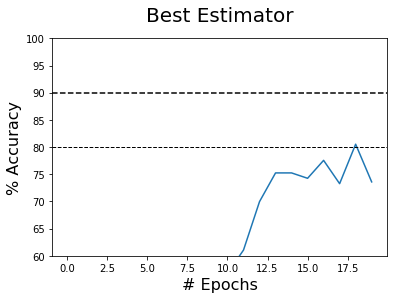

Baseline Cross Validation Score: 0.72277228 used {'batch_size': 20, 'epochs': 20}

CPU times: user 4.56 s, sys: 3.9 s, total: 8.46 s
Wall time: 6.63 s


In [13]:
%%time
# random seed to reproduce later
seed = 42
np.random.seed(seed)

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# instantiate model obj
model = KerasClassifier(build_fn=create_model, verbose=0)

# GridSearchCV hyperparameters
batch_size = [20]
epochs = [20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
c_v = StratifiedKFold(n_splits=4,
                      shuffle=True,
                      random_state=seed) # 4-fold CV

# instantiate GridSearchCV obj
cv_grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=c_v)

# run the cross validation
xval_result = cv_grid.fit(X, y)

# Plot the accuracy 
acc = [x*100 for x in xval_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('# Epochs', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Baseline Cross Validation Score: {xval_result.best_score_:.8f} used {xval_result.best_params_}\n")

### Hypertune Optimizers

Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) 

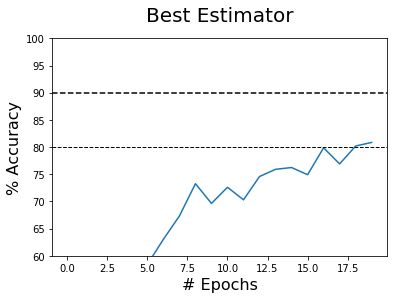

Best Cross Validation Score: 0.75907591 used {'batch_size': 20, 'epochs': 20, 'optimizer': 'nadam'}



NameError: name 'grid_result' is not defined

In [9]:
%%time
# Parameters -----------------------------------------------
batch_size = [20]
epochs = [20]
optimizer = ['adam','sgd','rmsprop','nadam']
param_grid = dict(batch_size=batch_size, 
                  epochs=epochs,
                  optimizer=optimizer)
# -----------------------------------------------

# random seed to reproduce later
seed = 42
np.random.seed(seed)

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(16, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# instantiate model obj
model = KerasClassifier(build_fn=create_model, verbose=1)

# GridSearchCV hyperparameters
c_v = StratifiedKFold(n_splits=4,
                      shuffle=True,
                      random_state=seed) # 4-fold CV

# instantiate GridSearchCV obj
cv_grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=c_v)

# run the cross validation
xval_result = cv_grid.fit(X, y)

# Plot the accuracy 
acc = [x*100 for x in xval_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('# Epochs', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best Cross Validation Score: {xval_result.best_score_:.8f} used {xval_result.best_params_}\n")
mean_scores = [x*100 for x in grid_result.cv_results_['mean_test_score']]
std_scores  = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(mean_scores, std_scorse, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 


### Hypertune Batch size


Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) 

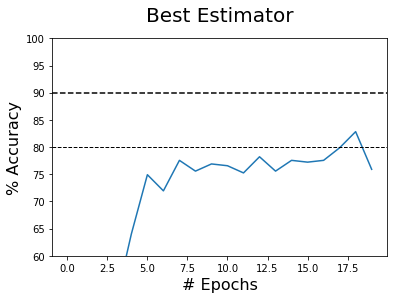

Best Cross Validation Score: 0.77557756 used {'batch_size': 10, 'epochs': 20}



NameError: name 'grid_result' is not defined

In [10]:
%%time
# Parameters -----------------------------------------------
batch_size = [10, 50, 100, 150, 250, 300]
epochs = [20]
param_grid = dict(batch_size=batch_size, 
                  epochs=epochs)
# -----------------------------------------------

# random seed to reproduce later
seed = 42
np.random.seed(seed)

def create_model(optimizer='nadam'):
    model = Sequential()
    model.add(Dense(16, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# instantiate model obj
model = KerasClassifier(build_fn=create_model, verbose=1)

# GridSearchCV hyperparameters
c_v = StratifiedKFold(n_splits=4,
                      shuffle=True,
                      random_state=seed) # 4-fold CV

# instantiate GridSearchCV obj
cv_grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=c_v)

# run the cross validation
xval_result = cv_grid.fit(X, y)

# Plot the accuracy 
acc = [x*100 for x in xval_result.best_estimator_.model.history.history['acc']]
fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('# Epochs', fontsize=16)
ax.set_ylabel('% Accuracy', fontsize=16)
ax.set_ylim(60,100)
ax.axhline(80, color='k', linestyle='--', linewidth=1)
ax.axhline(90, color='k', linestyle='--')
plt.title('Best Estimator', fontsize=20, y=1.05)
plt.show()

# Report Results
print(f"Best Cross Validation Score: {xval_result.best_score_:.8f} used {xval_result.best_params_}\n")
mean_scores = [x*100 for x in grid_result.cv_results_['mean_test_score']]
std_scores  = [x*100 for x in grid_result.cv_results_['std_test_score']]
params = xval_result.cv_results_['params']
for mean, stdev, param in zip(mean_scores, std_scorse, params):
    print(f"Means: {mean:.3f}, Stdev: {stdev:.3f} with: {param}") 